In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.lines as mlines
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout

### Hỗn hợp

In [42]:
honhop_folder = "data2/Honhop"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(honhop_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(honhop_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
honhop = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
honhop.columns = ['_'.join(map(str, col)) for col in honhop.columns]
honhop["File name"] = file_names
honhop["Type"] = honhop["File name"].str.split("-", expand=True)[0].str[0]

### Rễ

In [43]:
re_folder = "data2/Re"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(re_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(re_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
re = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
re.columns = ['_'.join(map(str, col)) for col in re.columns]
re["File name"] = file_names
re["Type"] = re["File name"].str.split("-", expand=True)[0].str[0]

### Thân

In [44]:
than_folder = "data2/Than"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(than_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(than_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
than = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
than.columns = ['_'.join(map(str, col)) for col in than.columns]
than["File name"] = file_names
than["Type"] = than["File name"].str.split("-", expand=True)[0].str[0]

In [45]:
data = pd.concat([honhop, re, than], axis=0)
data.shape

(119, 1871)

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data["Type"])

In [47]:
X = data.iloc[:, :-2]
wl = X.columns
X = savgol_filter(X, window_length = 25,  polyorder=5, deriv = 2)

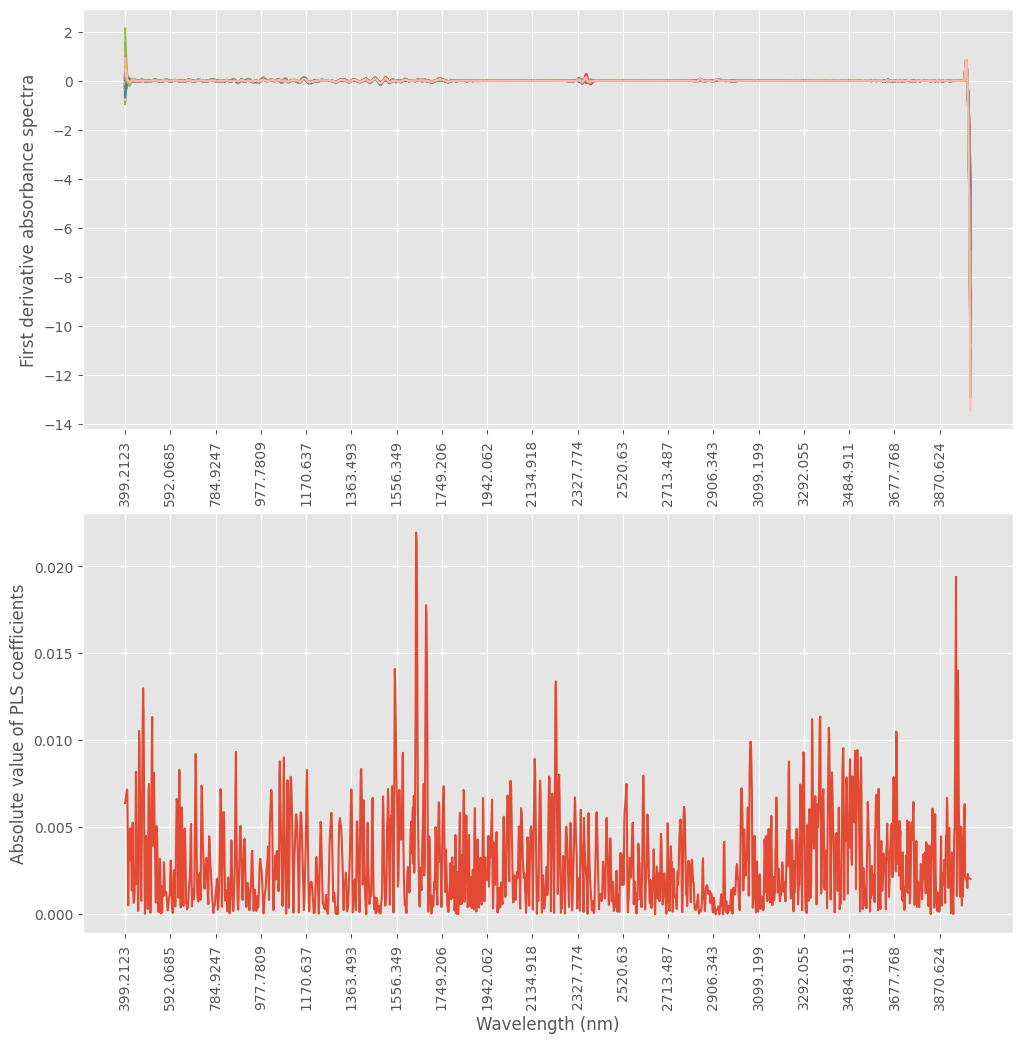

In [48]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(8)
pls.fit(X, y)


# print(np.abs(pls.coef_)reshape(-1,1))
plt.figure(figsize=(12,12))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_).reshape(-1,1))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    plt.show()

In [49]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(list(np.abs(pls.coef_)))
# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X[:,sorted_ind[0]]

In [50]:
Xc.shape

(119, 1869)

In [51]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(list(np.abs(pls1.coef_)))[0]
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            mse[i,j] = np.mean(1 - cross_val_score(pls2, Xc[:, j:], y, cv=5))
     
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    print(mse)
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(list(np.abs(pls.coef_)))[0]
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [52]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 15)

100% completed
[[3.08191112 3.08145063 3.08028277 ... 2.24196611 2.39332207 0.        ]
 [4.80863888 4.80916981 4.80759286 ... 3.86589301 0.         0.        ]
 [4.39103009 4.38974725 4.38852164 ... 0.         0.         0.        ]
 ...
 [4.9811478  4.95128967 4.93920005 ... 0.         0.         0.        ]
 [4.86078954 4.86122412 4.86045537 ... 0.         0.         0.        ]
 [4.869734   4.86395153 4.86591724 ... 0.         0.         0.        ]]
Optimised number of PLS components:  15
Wavelengths to be discarded  1306
Optimised MSEP  1.466893621158927


In [53]:
params = {
    'wav': wav,
    'sorted_ind': sorted_ind
}

In [54]:
### X[:,sorted_ind][:, wav:]

In [55]:
import pickle 
  
# Open a file and use dump() 
with open('file.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(params, file) 

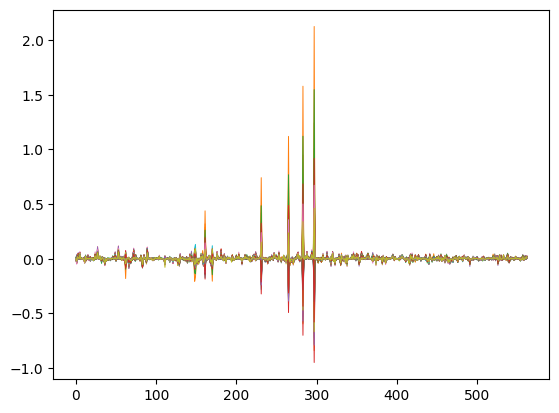

In [56]:
plt.plot(opt_Xc.T, linewidth = 0.7)
plt.show()

In [57]:
opt_Xc.shape

(119, 563)

In [58]:
wl_c = [float(i) for i in list(wl)]

C:\Users\84866\AppData\Local\Temp\ipykernel_4452\1139935945.py:13: MatplotlibDeprecationWarning:

The span_where function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use fill_between instead.

C:\Users\84866\AppData\Local\Temp\ipykernel_4452\1139935945.py:13: MatplotlibDeprecationWarning:

The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.



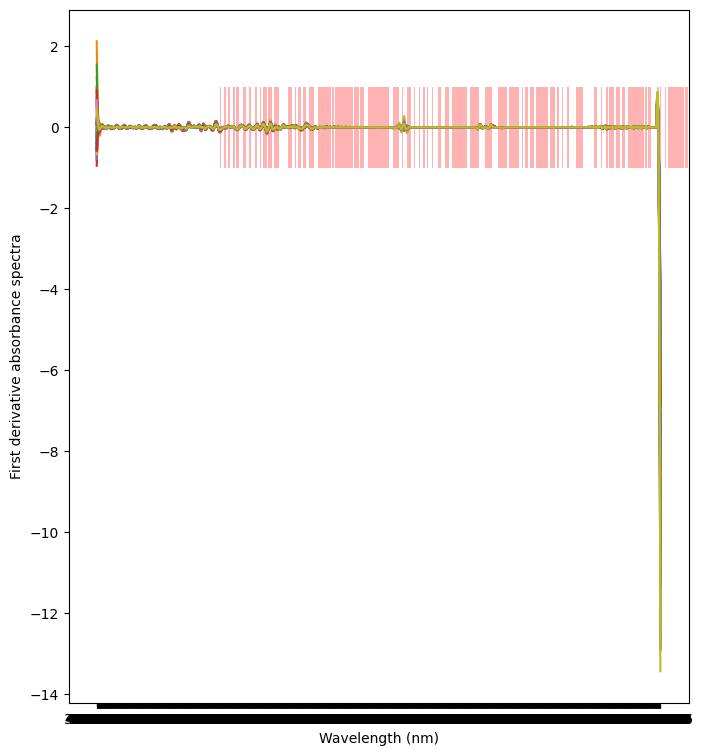

In [59]:
# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])
 
import matplotlib.collections as collections
 
# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')
 
collection = collections.BrokenBarHCollection.span_where(
    wl_c, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)
 
plt.show()

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(opt_Xc)

# save
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(scaled_data, y)

In [62]:
# save
with open('model.pkl','wb') as f:
    pickle.dump(lda,f)

In [63]:
import plotly.graph_objects as go


# Create a scatter plot
fig = go.Figure()
hover_text = data["File name"].values
color_map = {
    0: 'orange',
    1: 'blue',
    2: 'red'
}
# Add scatter trace
fig.add_trace(go.Scatter(
    x=X_lda[:, 0],
    y=X_lda[:, 1],
    mode='markers',  # Display markers and text
    marker=dict(
        size=10, 
        color = y,
        colorscale='Viridis', 
        colorbar=dict(title='Type', tickvals = [0,1,2], ticktext = ['Hỗn hợp', 'Rễ', 'Thân']),  
        showscale=True,
        line=dict(
            width=2,  # Width of the border
            color='black'  # Border color
        )
        ),
    hovertemplate = hover_text,

))

# Update layout
fig.update_layout(
    title='2D Scatter Plot Example',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    width = 600,
    height = 600,
)

# Show the plot
fig.show()

In [64]:
# Open the file in binary mode 
with open('file.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    params = pickle.load(file) 
  
    print(params) 

{'wav': 1306, 'sorted_ind': array([ 865, 1021, 1787, ...,  644, 1836,  643], dtype=int64)}


In [65]:
sorted_ind = params['sorted_ind']
wav = params['wav']
X_new = X[:,sorted_ind][:, wav:]

In [66]:
# load
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scale = pickle.load(f)

X_scaled = scale.transform(X_new)
print(X_scaled)
clf2.predict(X_scaled)

[[ 0.40559201 -0.82336327 -0.23583695 ...  1.06195526 -0.8727165
   1.28033834]
 [-0.07345256 -1.84879357  0.64463428 ...  1.89984228 -0.47074806
   1.58016171]
 [-4.49451485 -1.55903044  2.75604303 ...  3.32283059  1.59586371
   1.55089571]
 ...
 [ 0.02511396 -0.85091334 -1.51390175 ... -0.83475659  1.79119112
  -0.706929  ]
 [ 0.22037027 -0.72263596 -1.47170129 ... -0.71812787  0.03772983
  -0.69988737]
 [-0.77117612 -0.54937154 -1.17226272 ... -0.73308378  1.00164309
   0.39548136]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])